# Predicting if a Baby Will Have Low Birth Weight

Using Logistic Regression with PySpark

# Table of Contents

- [Low Birth Weight Data](#Low_Birth_Weight_Data)
- [Load Libraries](#Load_Libraries)
- [Load Data](#Load_Data) 
- [Function to Parse Data](#Function_to_Parse_Data)
- [Data Exploration](#Data_Exploration)
- [Split Data into Training and Test Sets](#Split_Data_into_Training_and_Test_Sets) 
- [Set Up ML Pipeline and Train the Logistic Regression Model](#Set_Up_ML_Pipeline_and_Train_the_Logistic_Regression_Model)
- [Predict withe the Model](#Predict_with_the_Model)
- [Testing the Model on the Test Set](#Testing_the_Model_on_the_Test_Set)
- [Evaluation](#Evaluation)
- [ROC Curve](#ROC_Curve)
- [Naive Bayes Model](#Try_Naive_Bayes_Classifier) 



# Low Birth Weight Data

Dataset source
Hosmer, D.W., Lemeshow, S. and Sturdivant, R.X. (2013) Applied Logistic Regression, 3rd ed., New York: Wiley


|| Variable      | Description |
|-----| :----------- | ----------- |
|0| ID	| Identification Code      | 
|1| LOW | Low birth weight (0: >= 2500, 1: < 2500 g) -  target variable | 
|2|AGE | Mother’s age in years |
|3|RACE | Race (1: White, 2: Black, 3: Other) | 
|4|SMOKE |Smoking status during pregnancy (0: No, 1: Yes) | 
|5|PTL | History of premature labor (0: None, 1: One, 2: Two, etc) |
|6|HT | History of hypertension (0: No, 1: Yes) | 
|7|UI | Presence of Uterine irritability (0: No, 1: Yes) |
|8|FTV | Number of physician visits during the first trimester (0: None, 1: One, 2: Two, etc) | 



#### Load Libraries

In [105]:
# PySpark Machine Learning Library
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import  NaiveBayes, MultilayerPerceptronClassifier
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row, SQLContext

import os
import sys
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *

from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.regression import LabeledPoint
from numpy import array

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Library for confusion matrix, precision, test error
from pyspark.mllib.evaluation import MulticlassMetrics
# Library For Area under ROC curve and Area under precision-recall curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Assign resources to the application
sqlContext = SQLContext(sc)

# packages for data analysis and data viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn


###  Load Data

#### Credentials

Import the data and create a data frame 
the first row is the names of the column headers and each column contains the values for that column

In [54]:

import ibmos2spark
# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-e330daf0-2ab8-417f-a5a4-b5d125ab3c6d',
    'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
    'api_key': 'lOUz9r8ysYA8NlT4Pk-DstWTUDFJ_3NIFSdq1S2tSqAv'
}

configuration_name = 'os_36a9b3f650574a1d8b2a40bfe5763c4d_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .load(cos.url('lowbwt.csv', 'apachesparktutorial-donotdelete-pr-8mcxrjcsl98upg'))
df_data_1.take(5)


[Row(ID=85, LOW=0, AGE=19, RACE=2, SMOKE=0, PTL=0, HT=0, UI=1, FTV=0),
 Row(ID=86, LOW=0, AGE=33, RACE=3, SMOKE=0, PTL=0, HT=0, UI=0, FTV=3),
 Row(ID=87, LOW=0, AGE=20, RACE=1, SMOKE=1, PTL=0, HT=0, UI=0, FTV=1),
 Row(ID=88, LOW=0, AGE=21, RACE=1, SMOKE=1, PTL=0, HT=0, UI=1, FTV=2),
 Row(ID=89, LOW=0, AGE=18, RACE=1, SMOKE=1, PTL=0, HT=0, UI=1, FTV=0)]

### Function to  Parse Data

The function will be used later to create a data frame with 3 columns.  the columns are an id column, a column with all the data as strings know as BabyInfo and the label for the target variable.  The second cell below will load the data into an array.

In [55]:
# the firs column is the id data the second column is the target (lbw) and the others are independent variables 
# the labeled document will hold the reorginized data
LabeledDocument = Row("ID", "BabyInfo", "label")
def parseDocument(line):
    values = [str(x) for x in line.split(',')] 
    if (values[1] > '0'):
        Low = 1.0
    else:
        Low = 0.0
        
    textValue = str(values[2]) + " " + str(values[3])+" " + str(values[4]) + " " + str(values[5]) + " " + str(values[6])+" " + str(values[7]) +  " " + str(values[8])
    return LabeledDocument(values[0], textValue, Low)

In [56]:
# load the data
data = sc.textFile(cos.url('lowbwt.csv', 'apachesparktutorial-donotdelete-pr-8mcxrjcsl98upg'))
print ("Total records in the data set:", data.count())
print ("The first 5 rows")
data.take(5)

Total records in the data set: 190
The first 5 rows


['ID,LOW,AGE,RACE,SMOKE,PTL,HT,UI,FTV',
 '85,0,19,2,0,0,0,1,0',
 '86,0,33,3,0,0,0,0,3',
 '87,0,20,1,1,0,0,0,1',
 '88,0,21,1,1,0,0,1,2']

In [57]:
#Parse and Load the data into a dataframe. The code calls the parsing function defined above
# the first line with the headers is skipped
documents = data.filter(lambda s: "I" not in s).map(parseDocument)
lbtwt= documents.toDF() # ToDataFrame
print ("Number of records: " + str(lbtwt.count()))
print ( "First 5 records: ")
lbtwt.take(5)

Number of records: 189
First 5 records: 


[Row(ID='85', BabyInfo='19 2 0 0 0 1 0', label=0.0),
 Row(ID='86', BabyInfo='33 3 0 0 0 0 3', label=0.0),
 Row(ID='87', BabyInfo='20 1 1 0 0 0 1', label=0.0),
 Row(ID='88', BabyInfo='21 1 1 0 0 1 2', label=0.0),
 Row(ID='89', BabyInfo='18 1 1 0 0 1 0', label=0.0)]

### Data Exploration

starting with size of the data set and proportion of the target and basic summary stats

In [58]:
print('Number of Babies', df_data_1.count())

Number of Babies 189


In [59]:
#Frequency of Target 
df_data_1.groupby('LOW').count().show()

+---+-----+
|LOW|count|
+---+-----+
|  1|   59|
|  0|  130|
+---+-----+



In [60]:
# check data types 
df_data_1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- LOW: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- RACE: integer (nullable = true)
 |-- SMOKE: integer (nullable = true)
 |-- PTL: integer (nullable = true)
 |-- HT: integer (nullable = true)
 |-- UI: integer (nullable = true)
 |-- FTV: integer (nullable = true)



In [61]:
# check for null values to id missing entries
df_data_1.toPandas().isnull().sum()

ID       0
LOW      0
AGE      0
RACE     0
SMOKE    0
PTL      0
HT       0
UI       0
FTV      0
dtype: int64

Summary Stats for all variables.  For categorical variables the mean will indicate how often the condition occurs.

In [62]:
df_data_1.toPandas().describe()

,ID,LOW,AGE,RACE,SMOKE,PTL,HT,UI,FTV
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,121.079365,0.312169,23.238095,1.846561,0.391534,0.195767,0.063492,0.148148,0.793651
std,63.303634,0.464609,5.298678,0.918342,0.489390,0.493342,0.244494,0.356190,1.059286
min,4.000000,0.000000,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,68.000000,0.000000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,123.000000,0.000000,23.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,176.000000,1.000000,26.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,226.000000,1.000000,45.000000,3.000000,1.000000,3.000000,1.000000,1.000000,6.000000


Histograms of all variables show the distribution.  Skewed or rare variables can be identified.

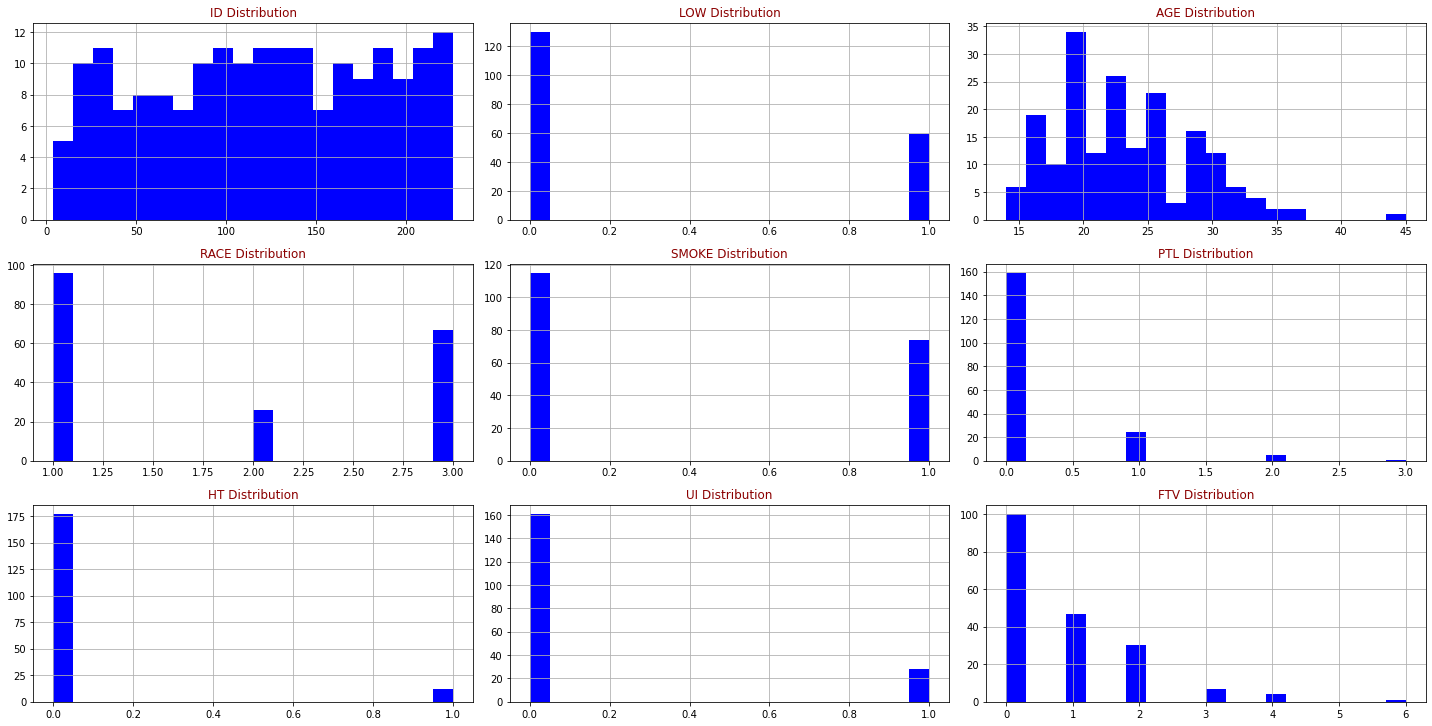

In [63]:
#Draw histogram for all variables
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax,facecolor='blue')
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(df_data_1.toPandas(), df_data_1.toPandas().columns,6,3)

First the numeric variables will be explored.  Correlations and relationships with the target variable will be explored and visualized.

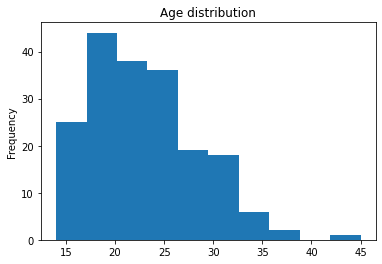

In [64]:
# Convert continous data type from string to numeric.
pdf=df_data_1.toPandas()
pdf["AGE"]=pd.to_numeric(pdf.AGE)
pdf["PTL"]=pd.to_numeric(pdf.PTL)
pdf["FTV"]=pd.to_numeric(pdf.FTV)

df=sqlContext.createDataFrame(pdf)

# histogram of age distribution
df.toPandas()["AGE"].plot.hist(x="Age", title="Age distribution")

Check for a pattern with low birth weight babies by comparing to the histogram of mother's ages for all babies and noting differences.

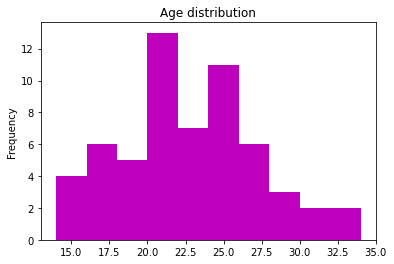

In [65]:
# plot the age hist of lbw
df_low=df.select('Age', 'LOW').filter(df['LOW']=='1')
pdf_low=df_low.select('Age').toPandas()
pdf_low.plot.hist('Age',  color='m',legend=False, title="Age distribution")

In [66]:
# summary stats for non categorical variables
df_data_1.describe( 'AGE', 'PTL', 'FTV').show()

+-------+------------------+-------------------+------------------+
|summary|               AGE|                PTL|               FTV|
+-------+------------------+-------------------+------------------+
|  count|               189|                189|               189|
|   mean|23.238095238095237|0.19576719576719576|0.7936507936507936|
| stddev|5.2986779334042655| 0.4933419132673032|1.0592861429875455|
|    min|                14|                  0|                 0|
|    max|                45|                  3|                 6|
+-------+------------------+-------------------+------------------+



In [67]:
# correlations of numeric variables and target variable in next three cells
df.stat.corr('AGE', 'LOW')

-0.11893928187018055

In [68]:
df.stat.corr('PTL', 'LOW')

0.19608726708242866

In [69]:
df.stat.corr('FTV', 'LOW')

-0.06296026092109269

Quick peek at which variables seem related by noting patterns of variable combinations.

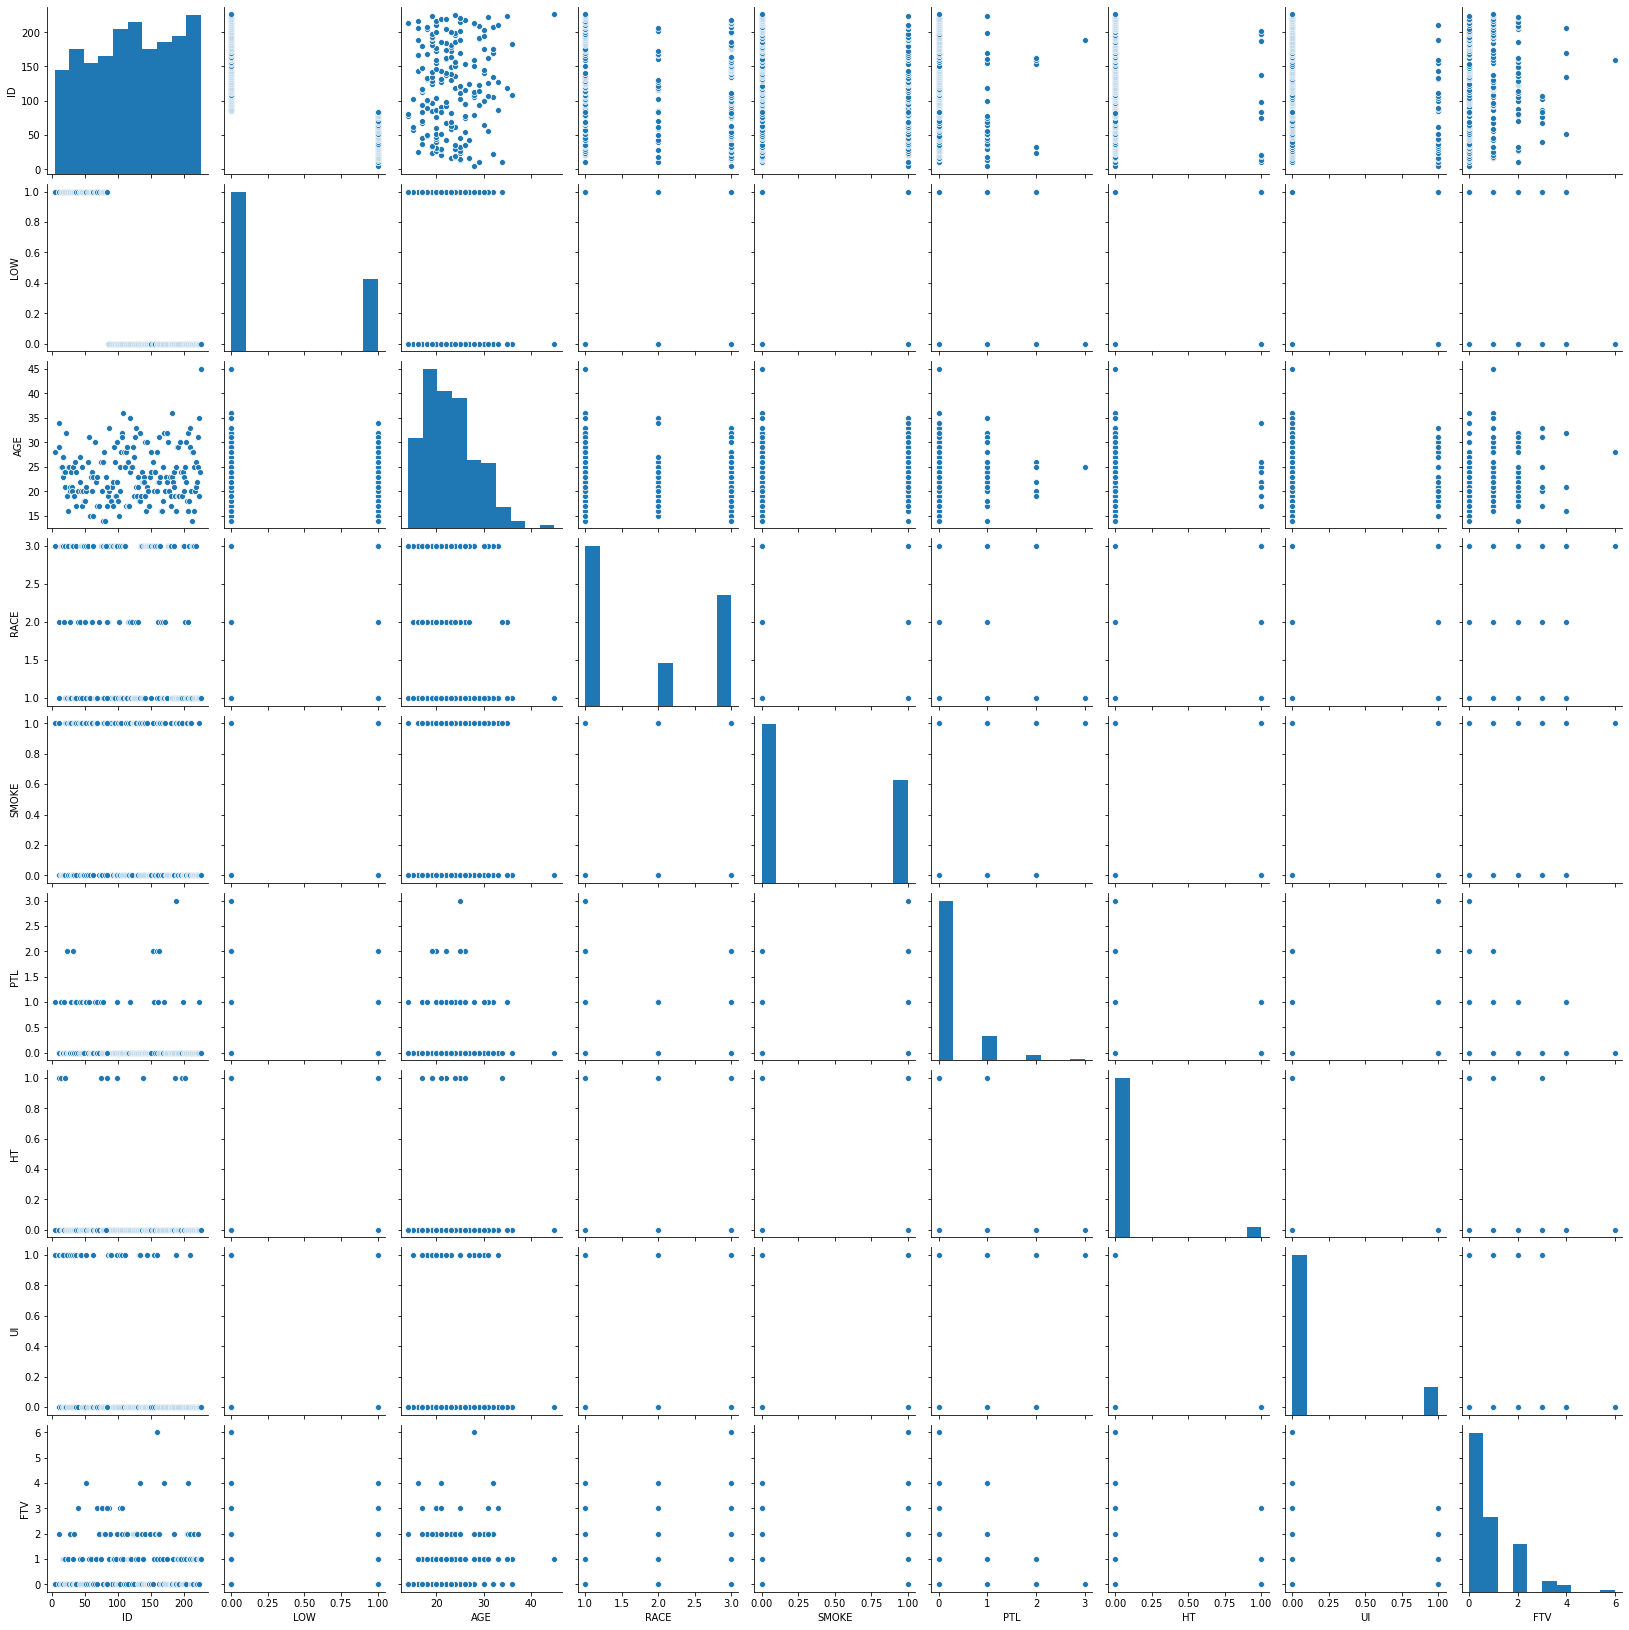

In [70]:
sn.pairplot(data=df_data_1.toPandas())

Now the mathematical relationships between all of the variables

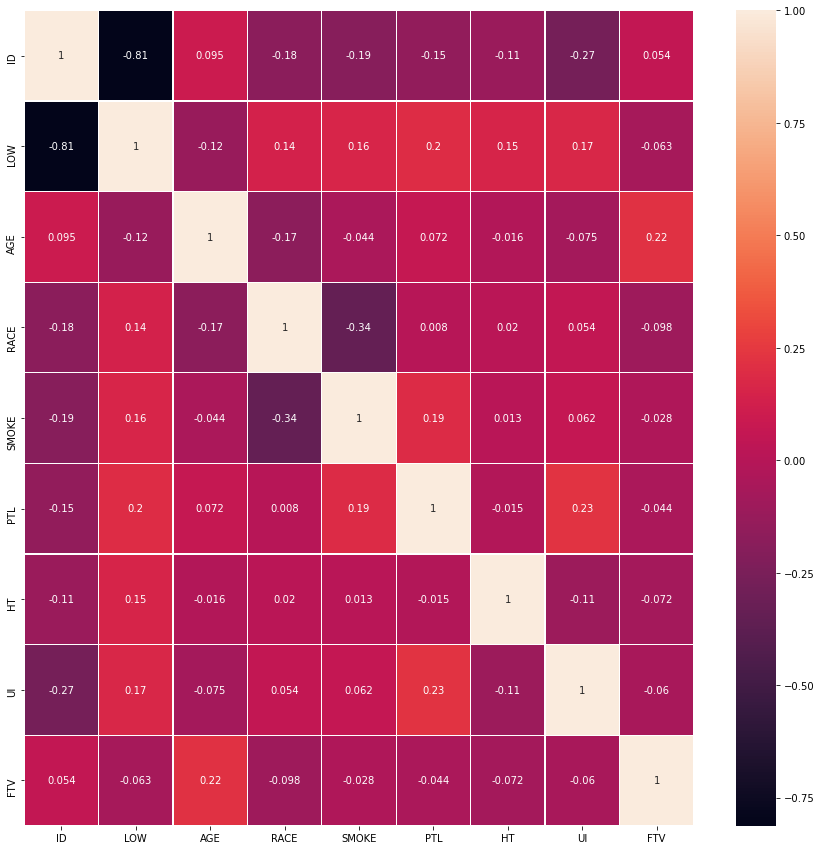

In [71]:
plt.figure(figsize=(15,15))
sn.heatmap(df_data_1.toPandas().corr(), annot=True, linewidths=0.1)

Explore the relationships between each variable and the target of low birth weight.

In [72]:
# relationships with target variable explored through the variation in means
PAge=df.groupby(['LOW'])\
.agg({"AGE": "AVG"}).toPandas()
PAge

,LOW,avg(AGE)
0,0,23.661538
1,1,22.305085


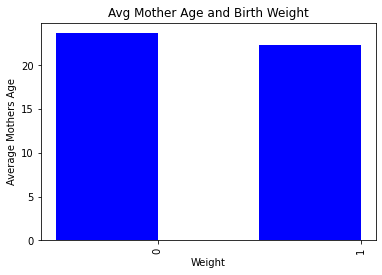

In [73]:
# visualize above
agelow=df.groupby(['LOW'])\
.agg({"AGE": "AVG"}).collect()

age=[]
Weight=[]
for row in agelow:
    Weight.append(row["LOW"])
    age.append(row["avg(AGE)"])
    
N = 2
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, age, bar_width,
                 color='b')
plt.xlabel('Weight')
plt.ylabel('Average Mothers Age')
plt.title('Avg Mother Age and Birth Weight')
plt.xticks(index + bar_width/2, Weight, rotation=90)
plt.show()

In [74]:
# average of premature labors for each target variable
PTLOW=df.groupby(['LOW'])\
.agg({"PTL": "AVG"}).toPandas()
PTLOW

,LOW,avg(PTL)
0,0,0.130769
1,1,0.338983


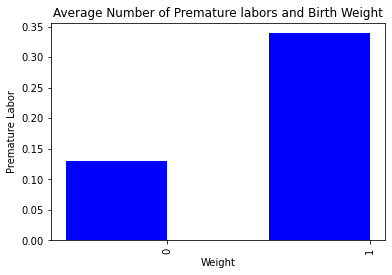

In [75]:
# visualize above
PTLOW=df.groupby(['LOW'])\
.agg({"PTL": "AVG"}).collect()

pre=[]
Weight=[]
for row in PTLOW:
    Weight.append(row["LOW"])
    pre.append(row["avg(PTL)"])
    
N = 2
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, pre, bar_width,
                 color='b')
plt.xlabel('Weight')
plt.ylabel('Premature Labor')
plt.title('Average Number of Premature labors and Birth Weight')
plt.xticks(index + bar_width/2, Weight, rotation=90)
plt.show()

In [76]:
# average physician visits aggregated by the target variable
FTVLOW=df.groupby(['LOW'])\
.agg({"FTV": "AVG"}).toPandas()
FTVLOW

,LOW,avg(FTV)
0,0,0.838462
1,1,0.694915


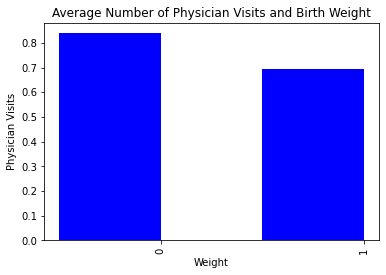

In [77]:
# here is the visual 
FTVLOW=df.groupby(['LOW'])\
.agg({"FTV": "AVG"}).collect()

vis = []
Weight=[]
for row in FTVLOW:
    Weight.append(row["LOW"])
    vis.append(row["avg(FTV)"])
    
N = 2
index = np.arange(N)  
bar_width = 0.5

plt.bar(index, vis, bar_width,
                 color='b')
plt.xlabel('Weight')
plt.ylabel('Physician Visits')
plt.title('Average Number of Physician Visits and Birth Weight')
plt.xticks(index + bar_width/2, Weight, rotation=90)
plt.show()

Now exploring the categorical variables and their relationship with the target variable.
Starting with smoking and birth weight.  The crosstabs show the breakdown of smokers vs non smokers and the number of lbw babies

+---------+---+---+
|SMOKE_LOW|  0|  1|
+---------+---+---+
|        1| 44| 30|
|        0| 86| 29|
+---------+---+---+



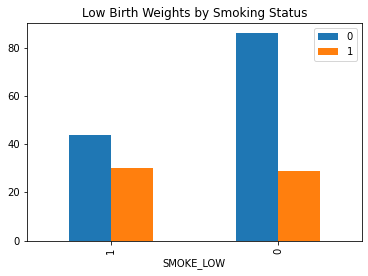

In [78]:
df_data_1.crosstab('SMOKE', 'LOW').show()
df1=df_data_1.crosstab('SMOKE', 'LOW').toPandas()
df1.plot.bar(x='SMOKE_LOW', legend=True , title="Low Birth Weights by Smoking Status") 

In [79]:
# show percentage of low birth weights for each variable
df1 = df_data_1.crosstab('SMOKE', 'LOW')
df1.withColumn("Proportion_Low", df1['1'] / (df1['1'] + df1['0']) * 100).show()


+---------+---+---+------------------+
|SMOKE_LOW|  0|  1|    Proportion_Low|
+---------+---+---+------------------+
|        1| 44| 30| 40.54054054054054|
|        0| 86| 29|25.217391304347824|
+---------+---+---+------------------+



In [80]:
# how many races are coded
df_data_1.select('RACE').distinct().show()

+----+
|RACE|
+----+
|   1|
|   3|
|   2|
+----+



+--------+---+---+
|RACE_LOW|  0|  1|
+--------+---+---+
|       2| 15| 11|
|       1| 73| 23|
|       3| 42| 25|
+--------+---+---+



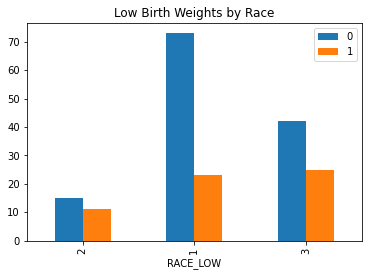

In [81]:
# now explore race and the target birth weight
df_data_1.crosstab('RACE', 'LOW').show()
df1=df_data_1.crosstab('RACE', 'LOW').toPandas()
df1.plot.bar(x='RACE_LOW', legend=True , title="Low Birth Weights by Race") 

In [82]:
# now the percentage of lbw for each race
df1 = df_data_1.crosstab('RACE', 'LOW')
df1.withColumn("Proportion_Low", df1['1'] / (df1['1'] + df1['0']) * 100).show()


+--------+---+---+------------------+
|RACE_LOW|  0|  1|    Proportion_Low|
+--------+---+---+------------------+
|       2| 15| 11| 42.30769230769231|
|       1| 73| 23|23.958333333333336|
|       3| 42| 25|  37.3134328358209|
+--------+---+---+------------------+



In [83]:
# how common is hypertension
df_data_1.groupby('HT').count().show() 

+---+-----+
| HT|count|
+---+-----+
|  1|   12|
|  0|  177|
+---+-----+



Now explore Hypertentsion and relationship with birth weight

+------+---+---+
|HT_LOW|  0|  1|
+------+---+---+
|     1|  5|  7|
|     0|125| 52|
+------+---+---+



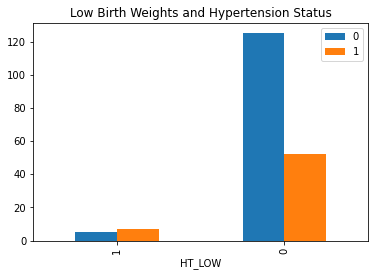

In [84]:
df_data_1.crosstab('HT', 'LOW').show()
df1=df_data_1.crosstab('HT', 'LOW').toPandas()
df1.plot.bar(x='HT_LOW', legend=True , title="Low Birth Weights and Hypertension Status") 

In [85]:
# now check the percentages of lbw for yes and no hypertension
df1 = df_data_1.crosstab('HT', 'LOW')
df1.withColumn("Proportion_Low", df1['1'] / (df1['1'] + df1['0']) * 100).show()


+------+---+---+------------------+
|HT_LOW|  0|  1|    Proportion_Low|
+------+---+---+------------------+
|     1|  5|  7|58.333333333333336|
|     0|125| 52| 29.37853107344633|
+------+---+---+------------------+



Now the same type of exploration with Uterine iritation

+------+---+---+
|UI_LOW|  0|  1|
+------+---+---+
|     1| 14| 14|
|     0|116| 45|
+------+---+---+



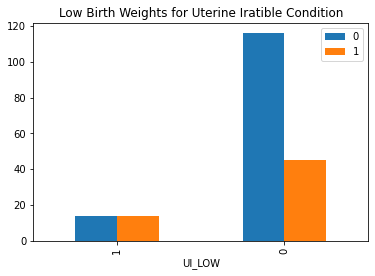

In [86]:
df_data_1.crosstab('UI','LOW').show()
df1=df_data_1.crosstab('UI', 'LOW').toPandas()
df1.plot.bar(x='UI_LOW', legend=True , title="Low Birth Weights for Uterine Iratible Condition") 

In [87]:
# how common is UI
df_data_1.groupby('UI').count().show() 


+---+-----+
| UI|count|
+---+-----+
|  1|   28|
|  0|  161|
+---+-----+



In [88]:
# percentage of UI and Lbw
df1 = df_data_1.crosstab('UI', 'LOW')
df1.withColumn("Proportion_Low", df1['1'] / (df1['1'] + df1['0']) * 100).show()


+------+---+---+-----------------+
|UI_LOW|  0|  1|   Proportion_Low|
+------+---+---+-----------------+
|     1| 14| 14|             50.0|
|     0|116| 45|27.95031055900621|
+------+---+---+-----------------+



+-------+---+---+
|RACE_HT|  0|  1|
+-------+---+---+
|      2| 23|  3|
|      1| 91|  5|
|      3| 63|  4|
+-------+---+---+



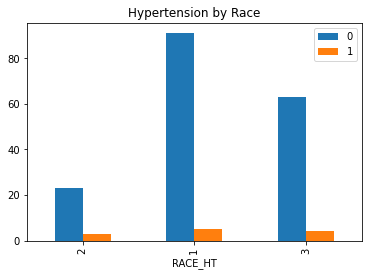

In [89]:
# check for collinearity between race and hypertension
df_data_1.crosstab('RACE', 'HT').show()
df1=df_data_1.crosstab('RACE', 'HT').toPandas()
df1.plot.bar(x='RACE_HT', legend=True , title="Hypertension by Race") 

In [90]:
# percentatge of hypertension for each race
df1 = df_data_1.crosstab('RACE', 'HT')
df1.withColumn("Proportion_HT", df1['1'] / (df1['1'] + df1['0']) * 100).show()


+-------+---+---+------------------+
|RACE_HT|  0|  1|     Proportion_HT|
+-------+---+---+------------------+
|      2| 23|  3|11.538461538461538|
|      1| 91|  5| 5.208333333333334|
|      3| 63|  4| 5.970149253731343|
+-------+---+---+------------------+



### Split Data into Training and Test Sets

In [91]:
# Divide the data into training and test set
(train, test) = lbtwt.randomSplit([0.8, 0.2])
print ("Number of records in the training set: " + str(train.count()))
print ("Number of records in the test set: " + str(test.count()))
# Output first 20 records in the training set
print ("First 20 records in the training set: ")
train.show()

Number of records in the training set: 153
Number of records in the test set: 36
First 20 records in the training set: 
+---+--------------+-----+
| ID|      BabyInfo|label|
+---+--------------+-----+
|100|18 1 1 0 0 0 0|  0.0|
|101|18 1 1 0 0 0 0|  0.0|
|102|15 2 0 0 0 0 0|  0.0|
|103|25 1 1 0 0 0 3|  0.0|
|104|20 3 0 0 0 1 0|  0.0|
|105|28 1 1 0 0 0 1|  0.0|
|106|32 3 0 0 0 0 2|  0.0|
|108|36 1 0 0 0 0 1|  0.0|
|109|28 3 0 0 0 0 0|  0.0|
|111|25 3 0 0 0 1 2|  0.0|
|112|28 1 0 0 0 0 0|  0.0|
|113|17 1 1 0 0 0 0|  0.0|
|114|29 1 0 0 0 0 2|  0.0|
|115|26 2 1 0 0 0 0|  0.0|
|116|17 2 0 0 0 0 1|  0.0|
|119|35 2 1 1 0 0 1|  0.0|
|120|25 1 0 0 0 0 1|  0.0|
|121|25 2 0 0 0 0 0|  0.0|
|123|29 1 1 0 0 0 2|  0.0|
|124|19 1 1 0 0 0 2|  0.0|
+---+--------------+-----+
only showing top 20 rows



### Set Up ML Pipeline and Train the Logistic Regression Model 

In [92]:
# set up Logistic Regression using Pipeline of SparkML
# pipeline breaks the string data into words and then vectorizes them before they are entered into Logistic regression model
tokenizer = Tokenizer(inputCol="BabyInfo", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01, threshold = .35)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

model = pipeline.fit(train)

### Predict withe the  Model
use the model to predict outcomes for the training set and tabulate the predicted and actual outcomes

In [93]:
prediction_train = model.transform(train)

In [94]:
#Tabulate the predicted outcome
prediction_train.select("prediction").groupBy("prediction").count().show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0.0       |93   |
|1.0       |60   |
+----------+-----+



In [95]:
#Tabulate the actual outcome
prediction_train.select("label").groupBy("label").count().show(truncate=False)

+-----+-----+
|label|count|
+-----+-----+
|0.0  |103  |
|1.0  |50   |
+-----+-----+



Now evaluate how the model performed on the training set using accuracy metrics

In [96]:
# Evaluate the Logistic Regression model on a training set
# Select (prediction, true label) and compute test error
pred_lr=model.transform(train).select("prediction", "label")
eval_lr=MulticlassClassificationEvaluator (
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr=eval_lr.evaluate(pred_lr)
# create RDD
predictionAndLabels_lr=pred_lr.rdd
metrics_lr=MulticlassMetrics(predictionAndLabels_lr)
precision_lr=metrics_lr.precision(1.0)
recall_lr=metrics_lr.recall(1.0)
f1Measure_lr = metrics_lr.fMeasure(1.0, 1.0)
print ("Model evaluation for the training data")
print ("Accuracy = %s" %accuracy_lr)
print ("Error = %s" % (1-accuracy_lr))
print ("Precision = %s" %precision_lr)
print ("Recall = %s" %recall_lr)
print("F1 Measure = %s" % f1Measure_lr)

Model evaluation for the training data
Accuracy = 0.7254901960784313
Error = 0.27450980392156865
Precision = 0.5666666666666667
Recall = 0.68
F1 Measure = 0.6181818181818183


### Testing the Model on the Test Set

Same as above predicting, tabulating and evaluating but now using the test set not used to train the model

In [97]:
prediction = model.transform(test)
selected = prediction.select("BabyInfo", "prediction", "probability")
# now show the predicted values and confidence the model has for each possibility 
for row in selected.collect():
    print (row)

Row(BabyInfo='31 1 0 0 0 1 3', prediction=0.0, probability=DenseVector([0.6785, 0.3215]))
Row(BabyInfo='17 2 0 0 0 0 1', prediction=1.0, probability=DenseVector([0.5875, 0.4125]))
Row(BabyInfo='24 1 1 1 0 0 1', prediction=1.0, probability=DenseVector([0.1902, 0.8098]))
Row(BabyInfo='27 1 1 0 0 0 0', prediction=1.0, probability=DenseVector([0.0279, 0.9721]))
Row(BabyInfo='18 1 1 0 0 1 0', prediction=0.0, probability=DenseVector([0.8012, 0.1988]))
Row(BabyInfo='22 3 1 0 0 0 0', prediction=0.0, probability=DenseVector([0.8866, 0.1134]))
Row(BabyInfo='22 1 1 0 0 0 0', prediction=0.0, probability=DenseVector([0.8962, 0.1038]))
Row(BabyInfo='16 3 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.8585, 0.1415]))
Row(BabyInfo='30 3 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.9379, 0.0621]))
Row(BabyInfo='17 3 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.6922, 0.3078]))
Row(BabyInfo='28 1 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.8547, 0.1453]))
Row(BabyIn

In [98]:
#Tabulate the predicted outcome
prediction.select("prediction").groupBy("prediction").count().show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0.0       |24   |
|1.0       |12   |
+----------+-----+



In [99]:
#Tabulate the actual outcome by label value
prediction.select("label").groupBy("label").count().show(truncate=False)

+-----+-----+
|label|count|
+-----+-----+
|0.0  |27   |
|1.0  |9    |
+-----+-----+



### Evaluation
same as above but now on test set

In [100]:
# confusion matrix
# 0 is healthy birth weight and 1 is low birth weight
# The rows show actual values and the columns predicted values
prediction.crosstab('label', 'prediction').show()

+----------------+---+---+
|label_prediction|0.0|1.0|
+----------------+---+---+
|             1.0|  3|  6|
|             0.0| 21|  6|
+----------------+---+---+



In [101]:
# Evaluate the Logistic Regression model on a test set
# Select (prediction, true label) and compute test error and other metrics of accuracy
pred_lr=model.transform(test).select("prediction", "label")
eval_lr=MulticlassClassificationEvaluator (
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_lr=eval_lr.evaluate(pred_lr)
# create RDD
predictionAndLabels_lr=pred_lr.rdd
metrics_lr=MulticlassMetrics(predictionAndLabels_lr)
precision_lr=metrics_lr.precision(1.0)
recall_lr=metrics_lr.recall(1.0)
f1Measure_lr = metrics_lr.fMeasure(1.0, 1.0)
print ("Model evaluation for the test data")
print ("Accuracy = %s" %accuracy_lr)
print ("Error = %s" % (1-accuracy_lr))
print ("Precision = %s" %precision_lr)
print ("Recall = %s" %recall_lr)
print ("F1 Measure = %s" % f1Measure_lr)

Model evaluation for the test data
Accuracy = 0.75
Error = 0.25
Precision = 0.5
Recall = 0.6666666666666666
F1 Measure = 0.5714285714285715


In [102]:
# additional metrics of model strength 
bin_lr=BinaryClassificationMetrics(predictionAndLabels_lr)

# Area under precision-recall curve
print("Area under PR = %s" % bin_lr.areaUnderPR)
# Area under Receiver operating characteristic curve
print("Area under ROC = %s" % bin_lr.areaUnderROC)

Area under PR = 0.4583333333333333
Area under ROC = 0.7222222222222222


### ROC Curve

plot the curve to see the model predictive ability

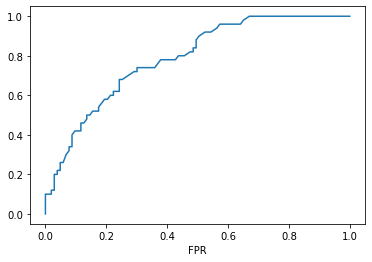

In [103]:
ROC=model.stages[2].summary.roc
df=ROC.toPandas()

df.plot(x='FPR', y='TPR', legend=False)

### Try Naive Bayes Classifier

In [108]:
# set up Naive Bayes using Pipeline of SparkML
tokenizer = Tokenizer(inputCol="BabyInfo", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
nb = NaiveBayes(labelCol="label", featuresCol="features", predictionCol="prediction", smoothing=1.0, modelType="multinomial")
pipeline = Pipeline(stages=[tokenizer, hashingTF, nb])
# set up Naive Bayes Model
# the stages are executed in order
model = pipeline.fit(train)

<a id="test_data"></a>
## Predict for Test data

In [109]:
# Make predictions for test data and print columns of interest
prediction = model.transform(test)
selected = prediction.select("BabyInfo", "prediction", "probability")
for row in selected.collect():
    print (row)

Row(BabyInfo='31 1 0 0 0 1 3', prediction=0.0, probability=DenseVector([0.9941, 0.0059]))
Row(BabyInfo='17 2 0 0 0 0 1', prediction=0.0, probability=DenseVector([0.9943, 0.0057]))
Row(BabyInfo='24 1 1 1 0 0 1', prediction=0.0, probability=DenseVector([0.9893, 0.0107]))
Row(BabyInfo='27 1 1 0 0 0 0', prediction=0.0, probability=DenseVector([0.9812, 0.0188]))
Row(BabyInfo='18 1 1 0 0 1 0', prediction=0.0, probability=DenseVector([0.9977, 0.0023]))
Row(BabyInfo='22 3 1 0 0 0 0', prediction=0.0, probability=DenseVector([0.9986, 0.0014]))
Row(BabyInfo='22 1 1 0 0 0 0', prediction=0.0, probability=DenseVector([0.9986, 0.0014]))
Row(BabyInfo='16 3 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.9982, 0.0018]))
Row(BabyInfo='30 3 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.9985, 0.0015]))
Row(BabyInfo='17 3 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.9956, 0.0044]))
Row(BabyInfo='28 1 0 0 0 0 0', prediction=0.0, probability=DenseVector([0.9978, 0.0022]))
Row(BabyIn

In [110]:
#Tabulate the predicted outcome
prediction.select("prediction").groupBy("prediction").count().show(truncate=False)

+----------+-----+
|prediction|count|
+----------+-----+
|0.0       |36   |
+----------+-----+



In [111]:
#Tabulate the actual outcome
prediction.select("label").groupBy("label").count().show(truncate=False)

+-----+-----+
|label|count|
+-----+-----+
|0.0  |27   |
|1.0  |9    |
+-----+-----+



In [112]:
prediction.crosstab('label', 'prediction').show()

+----------------+---+
|label_prediction|0.0|
+----------------+---+
|             1.0|  9|
|             0.0| 27|
+----------------+---+



The NB classifier predicted all from the majority class.  Having this model adds no benefit.